In [14]:
%pylab inline 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from helper import get_colors

Populating the interactive namespace from numpy and matplotlib


In [15]:
!pwd

/Users/ntokoven/Dropbox/_Education/_UvA/_Thesis/information-bottleneck


In [16]:
get_x, get_y = lambda x: x[0], lambda x: x[1]
colors = get_colors(4)
col = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}
def get_max_from_df(df):
    return df.apply(get_x).max(axis=0), df.apply(get_y).max(axis=0)

def get_mean_convergence(df, window=300):
    return df['X'][-window:].mean(axis=0), df['Y'][-window:].mean(axis=0)

In [17]:
!pwd

/Users/ntokoven/Dropbox/_Education/_UvA/_Thesis/information-bottleneck


In [18]:
date = '2007'
experiment_path = 'experiments_%s/' % date
if date == 2604:
    title = r'784->1024->1024->'+r'$\mathbf{1024}$'+r'->1024->256'
    print(title)
if date == 2104:
    title = r'784->1024->1024->'+r'$\mathbf{256}$'
    print(title)
if date == '0905':
    title = r'784->1024->1024->'+r'$\mathbf{256}$'+r'->64->64->10'
if date == '0506':
    title = r'784->1024->1024->'+r'$\mathbf{256}$'+r'->64->64->10'


experiment_path = 'experiments_2007/'
cifar10_title = 'CIFAR10' #'VGG11'
mnist12k_title = 'MNIST12k' #r'784->1024->1024->'+r'$\mathbf{256}$'+r'->64->64->10'
print(experiment_path, title)

experiments_2007/ <function title at 0x132970f28>


In [19]:
def create_colors(vals_df, maximum=10, minimum=2):
    red = Color("blue")
    colors = list(red.range_to(Color("white"),101))
    for i in wd_abc.index.values:
        tmp = wd_abc.loc[i, 2]
        wd_abc.loc[i, 2] = transform(tmp[0], tmp[1])

    quantization = np.linspace(minimum, maximum, 101)
    colors_vals = pd.Series(index=wd_abc.index)

    for i in wd_abc.index.values:
        for j in range(len(quantization) - 1):
            if wd_abc.loc[i, 2][0] > quantization[j] and wd_abc.loc[i, 2][0] <= quantization[j+1]:
                colors_vals.loc[i] = quantization[j]
            
    final_colors = colors_vals.fillna(0).apply(lambda x: int(x*maximum)).apply(lambda x: colors[x])
    return final_colors

In [215]:
def make_mie_df(vals, dataset, layers, reg_type, comment=''):
    mie_df = pd.DataFrame(columns=layers)
    if reg_type == 'wd':
        folder = dataset+'/wd'
    elif reg_type == 'dout':
        folder = dataset+'/dropout'
    elif reg_type == 'vib':
        folder = dataset+'/vib'
    elif reg_type == 'ceb' or reg_type == 'cvib':
        folder = dataset+'/ceb'

    for val in vals:
        try:
            if comment != '':
                path = experiment_path + 'mie/%s/%s/%s' % (folder, str(val), comment)
            else:
                path = experiment_path + 'mie/%s/%s' % (folder, str(val))
#             path += '/mie_max_values'
            path += '/mie_train_values'
            f_names = sort(os.listdir(path))
            for j in range(len(f_names)):
                #if f_names[j] != '.DS_Store':
                    #for layer in layers:
#                         name = re.findall('Linear%d' % layer, f_names[j])
#                         print(name)
#                         if len(name) > 0:
#                             name = name[0]
#                             layer = int(re.sub('\D', '', name))

#                 res_str = pd.Series.from_csv(path+'/'+f_names[j], sep=' ')['Linear0']
#                 mie_df.loc[val, 2] = [float(_) for _ in re.sub('[(]|[)]', '', res_str).split(', ')]
                res_str = get_mean_convergence(pd.DataFrame.from_csv(path+'/'+f_names[j], sep=' '))
                #if res_str[0] > 0.1:
                mie_df.loc[val, 2] = res_str
                #else:
                #    pass
        except FileNotFoundError:
            print('MIE experiment for %s with %s (%s) for %s is missing' % (comment, reg_type, val, dataset))
#     return get_mean_convergence(mie_df)
    print(mie_df)
    return mie_df

def make_abc_df(vals, dataset, layers, reg_type, comment=''):
    abc_df = pd.DataFrame(columns=layers)
    if reg_type == 'wd':
        folder = dataset+'/wd'
    elif reg_type == 'dout':
        folder = dataset+'/dropout'
    elif reg_type == 'vib':
        folder = dataset+'/vib'
    elif reg_type == 'ceb' or reg_type == 'cvib':
        folder = dataset+'/ceb'
    path = experiment_path + 'results/%s/abc_values/' % dataset
    f_names = sort(os.listdir(path))
    for j in range(len(f_names)):
        if f_names[j] != '.DS_Store':
            for val in vals:
#                 if comment != '':
#                     path += '/%s/%s' % (str(val), comment)
#                 else:
#                     path += '/%s' % str(val)
                for layer in layers:
#                     target_name = re.compile(r'%s_{[0-9]}_%s' % (reg_type, val))
                    for num in range(0, len(vals)):
                        if comment != '':
                            final_path = path+r'%s_%s_{%d}_%s.csv' % (reg_type, comment, num, val)
                        else:
                            final_path = path+r'%s_{%d}_%s.csv' % (reg_type, num, val)
                        if os.path.exists(final_path):
                            name = final_path
                            try:
                                a = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[0]['Linear%d'%layer]
                                b = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[1]['Linear%d'%layer]
                                abc_df.loc[val, layer] = (a, b)
                            except:
                                a = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[0]['Linear0']
                                b = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[1]['Linear0']
                                abc_df.loc[val, layer] = (a, b)
    for l in layers:
        for i in abc_df.index.values:
            abc_df.loc[i, l] = transform(abc_df.loc[i, l][0], abc_df.loc[i, l][1])
    print(abc_df)
    return abc_df
'''
def old_information_plane(mi_df, dataset, abc_df, reg_type, fig, ax, folder='information_planes',c=False, final_c=False, name=False, loc=False, title=False, comment='', tog=False, biases = {}, annotate=True):
    params_vals = mi_df.index.values
    layers = mi_df.columns.values
    colors = get_colors(len(layers))
    set_legend = True
    if comment == 'stoch':
        comment = 'Stochastic'
    if comment == 'determ':
        comment = 'Deterministic'
    if comment == 'unit':
        comment = r'CVIB ($\sigma$=1)'
    if comment == 'learnt':
        comment = r'CVIB ($\sigma$ trained)'
    if reg_type == 'vib':
        comment = 'VIB'
        
    for j in range(len(layers)):
        l = layers[j]
        for i in range(len(params_vals)):
            #try:
                p = params_vals[i]
                if set_legend:
                    if folder == 'gap':
#                         ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=c if c else colors[l], label='reg_type=%s %s' % (reg_type, comment))
                        ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=c if c else colors[l], label='%s' % (comment))
                    else:
#                         ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l], label='reg_type=%s %s' % (reg_type, comment))
                        ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l], label='%s' % (comment))


                    ax.legend(loc=loc if loc else 'best')#4)
                else:
                    if folder == 'gap':
                        ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=c if c else colors[l])
                    else:
                        ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l])
                if folder == 'gap':
#                     ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (p, mi_df.loc[p, l][0]+0.1 - mi_df.loc[p, l][1]))
                    pass
                else:
#                     ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (mi_df.loc[p, l][0]+0.02, mi_df.loc[p, l][1]))
                    # annotate with only parameter value
                    if p in biases.keys():
                        bias = biases[p]
                    else:
                        bias = [0.04, 0]
#                     if (p == '1e-4' or p == '1e-6') and comment == 'Stochastic':
#                         bias = [-0.24,0]
                    if annotate:
                        ax.annotate('(%s)' % p, (mi_df.loc[p, l][0]+bias[0], mi_df.loc[p, l][1]+bias[1]))


    #             ax.annotate('%s %s' % (reg_type, p), (mi_df.loc[p, l][0]+0.01, mi_df.loc[p, l][1]-0.0075))
                ax.grid()
                set_legend = False
            #except KeyError:
                
                #print('GC experiment for %s with %s (%s) is missing' % (comment, reg_type, p))
        if not c:
            set_legend = True
        if folder != 'gap':
            ax.plot(mi_df[l].apply(get_x).values, mi_df[l].apply(get_y).values, color=c if c else colors[l])
        ax.set_title(title if title else reg_type+' (param_val, ABC)')
    if folder != 'gap':
        fig.text(0.5, 0.04, 'I(X, Z)', ha='center')
        fig.text(0.04, 0.5, 'I(Z, Y)', va='center', rotation='vertical')
    else:
        fig.text(0.5, 0.04, r'$\beta$', ha='center')
        fig.text(0.04, 0.5, 'I(X, Z|Y)', va='center', rotation='vertical')
    fig.set_size_inches(10, 7, forward=True)
    if not os.path.exists(experiment_path+'results/%s/%s' % (dataset, folder)):
        os.makedirs(experiment_path+'results/%s/%s' % (dataset, folder))
    fig.show()
    if comment != '':
        save_path = experiment_path+'results/%s/%s/%s%s.png' % (dataset, folder, name if name else reg_type, '_'+comment if not tog else '')
        print(save_path)
        fig.savefig(experiment_path+'results/%s/%s/%s%s.png' % (dataset, folder, name if name else reg_type, '_'+comment if not tog else ''))
    else:
        save_path = experiment_path+'results/%s/%s/%s.png' % (dataset, folder, name if name else reg_type)
        print(save_path)
        fig.savefig(experiment_path+'results/%s/%s/%s.png' % (dataset, folder, name if name else reg_type))
    print('saved information plane')
    return fig, ax

'''


def information_plane(mi_dfs, dataset, abc_df, reg_type, fig, ax, folder='information_plane',c=False, final_c=False, name=False, loc=False, title=False, comment='', tog=False, biases = {}, annotate=True):
    params_vals = mi_dfs[0].index.values
    layers = mi_dfs[0].columns.values
    colors = get_colors(len(layers))
    set_legend = True
    if comment == 'stoch':
        comment = 'Stochastic'
    if comment == 'determ':
        comment = 'Deterministic'
    if comment == 'unit':
        comment = r'CVIB ($\sigma$=1)'
    if comment == 'learnt':
        comment = r'CVIB ($\sigma$ trained)'
    if reg_type == 'vib':
        comment = 'VIB'
    comments = ['VIB', r'CVIB ($\sigma$=1)', r'CVIB ($\sigma$ trained)']
    colors = ['red', 'green', 'orange']
    #for m in range(len(mi_dfs)):
#         mi_df = mi_dfs[m]
#         comment = comments[m]
#         c = colors[m]
    for j in range(len(layers)):
        l = layers[j]
        for i in range(len(params_vals)):
            #try:
                p = params_vals[i]
                if set_legend:
                    if folder == 'gap':
                        for m in range(len(mi_dfs)):
                            mi_df = mi_dfs[m]
                            comment = comments[m]
                            c = colors[m]
                        #                         ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=c if c else colors[l], label='reg_type=%s %s' % (reg_type, comment))
                            ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=c if c else colors[l], label='%s' % (comment))
                    else:
#                         ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l], label='reg_type=%s %s' % (reg_type, comment))
                        ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l], label='%s' % (comment))


                    ax.legend(loc=4)#loc if loc else 'best')#4)
                else:
                    if folder == 'gap':
                        r1 = np.arange(len(bars1))
                        r2 = [x + barWidth for x in r1]
                        r3 = [x + barWidth for x in r2]

                        for m in range(len(mi_dfs)):
                            mi_df = mi_dfs[m]
                            comment = comments[m]
                            c = colors[m]
                            ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=c if c else colors[l])
                    else:
                        ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l])
                if folder == 'gap':
#                     ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (p, mi_df.loc[p, l][0]+0.1 - mi_df.loc[p, l][1]))
                    pass
                else:
#                     ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (mi_df.loc[p, l][0]+0.02, mi_df.loc[p, l][1]))
                    # annotate with only parameter value
                    if p in biases.keys():
                        bias = biases[p]
                    else:
                        bias = [0.04, 0]
#                     if (p == '1e-4' or p == '1e-6') and comment == 'Stochastic':
#                         bias = [-0.24,0]
                    if annotate:
                        ax.annotate('(%s)' % p, (mi_df.loc[p, l][0]+bias[0], mi_df.loc[p, l][1]+bias[1]))


    #             ax.annotate('%s %s' % (reg_type, p), (mi_df.loc[p, l][0]+0.01, mi_df.loc[p, l][1]-0.0075))
                ax.grid()
                set_legend = False
            #except KeyError:

                #print('GC experiment for %s with %s (%s) is missing' % (comment, reg_type, p))
        if not c:
            set_legend = True
        if folder != 'gap':
            ax.plot(mi_df[l].apply(get_x).values, mi_df[l].apply(get_y).values, color=c if c else colors[l])
        ax.set_title(title if title else reg_type+' (param_val, ABC)')
    if folder != 'gap':
        fig.text(0.5, 0.04, 'I(X, Z)', ha='center')
        fig.text(0.04, 0.5, 'I(Z, Y)', va='center', rotation='vertical')
    else:
        fig.text(0.5, 0.04, r'$\beta$', ha='center')
        fig.text(0.04, 0.5, 'I(X, Z|Y)', va='center', rotation='vertical')
    fig.set_size_inches(10, 7, forward=True)
    if not os.path.exists(experiment_path+'results/%s/%s' % (dataset, folder)):
        os.makedirs(experiment_path+'results/%s/%s' % (dataset, folder))
    fig.show()
    if comment != '':
        save_path = experiment_path+'results/%s/%s/%s%s.png' % (dataset, folder, name if name else reg_type, '_'+comment if not tog else '')
        print(save_path)
        fig.savefig(experiment_path+'results/%s/%s/%s%s.png' % (dataset, folder, name if name else reg_type, '_'+comment if not tog else ''))
    else:
        save_path = experiment_path+'results/%s/%s/%s.png' % (dataset, folder, name if name else reg_type)
        print(save_path)
        fig.savefig(experiment_path+'results/%s/%s/%s.png' % (dataset, folder, name if name else reg_type))
    print('saved information plane')
    return fig, ax





# def information_plane(mi_df, dataset, abc_df, reg_type, fig, ax, folder='information_planes',c=False, final_c=False, name=False, loc=False, title=False, comment='', tog=False):
#     params_vals = mi_df.index.values
#     layers = mi_df.columns.values
#     colors = get_colors(len(layers))
#     set_legend = True
#     for j in range(len(layers)):
#         l = layers[j]
#         for i in range(len(params_vals)):
#             #try:
#                 p = params_vals[i]
#                 if set_legend:
#                     if folder == 'gap':
#                         ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=final_c.loc[p].rgb, label='reg_type=%s %s' % (reg_type, comment))
#                     else:
#                         ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], c=final_c.loc[p].rgb, label='reg_type=%s %s' % (reg_type, comment))
#                     ax.legend(loc=loc if loc else 'best')#4)
#                 else:
#                     if folder == 'gap':
#                         ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=final_c.loc[p].rgb)
#                     else:
#                         ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], c=final_c.loc[p].rgb)
#                 if folder == 'gap':
#                     ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (p, mi_df.loc[p, l][0]+0.1 - mi_df.loc[p, l][1]))
#                 else:
#                     ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (mi_df.loc[p, l][0]+0.02, mi_df.loc[p, l][1]))
#     #             ax.annotate('%s %s' % (reg_type, p), (mi_df.loc[p, l][0]+0.01, mi_df.loc[p, l][1]-0.0075))
#                 ax.grid()
#                 set_legend = False
#             #except KeyError:
                
#                 #print('GC experiment for %s with %s (%s) is missing' % (comment, reg_type, p))
#         if not c:
#             set_legend = True
#         if folder != 'gap':
#             ax.plot(mi_df[l].apply(get_x).values, mi_df[l].apply(get_y).values)#, color=c if c else colors[l])
#         ax.set_title(title if title else reg_type+' (param_val, ABC)')

#     fig.text(0.5, 0.04, 'I(X, Z)', ha='center')
#     fig.text(0.04, 0.5, 'I(Z, Y)', va='center', rotation='vertical')
#     fig.set_size_inches(10, 7, forward=True)
#     if not os.path.exists(experiment_path+'results/%s/%s' % (dataset, folder)):
#         os.makedirs(experiment_path+'results/%s/%s' % (dataset, folder))
#     fig.show()
#     if comment != '':
#         fig.savefig(experiment_path+'results/%s/%s/%s%s.png' % (dataset, folder, name if name else reg_type, '_'+comment if not tog else ''))
#     else:
#         fig.savefig(experiment_path+'results/%s/%s/%s.png' % (dataset, folder, name if name else reg_type))
#     print('saved information plane')
#     return fig, ax




def new_build(fig, ax, vals, dataset, reg_type, color, folder='information_planes', comment='', name=False, tog=False, loc=False, biases={}, annotate=True):
    if dataset == 'cifar10':
        title = cifar10_title
    elif dataset == 'mnist12k':
        title = mnist12k_title
    types = [('vib', ''), ('ceb', 'unit'), ('ceb', 'learnt')]
    abc = make_abc_df(vals, dataset, layers, reg_type, comment=comment)
    mies = [make_mie_df(vals, dataset, layers, reg_type, comment=comment) for (reg_type, comment) in types]
    print(mies)
    if fig is None:
        fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
#     fig, ax = new_information_plane(mies, dataset, abc, reg_type, fig, ax, folder=folder, c=color, name=name, loc=loc, title=title, comment=comment, tog=tog, biases=biases, annotate=annotate)
#     fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
#     _ = information_plane(mie, dataset, abc, reg_type, fig, ax, folder='gap', c=col['wd'], name=name, title=title, comment=comment, tog=tog)
    return fig, ax, mies

def transform(val_a, val_b, maximum=2.980196957073414, minimum=0):
    val_a = val_a / maximum * 100
    val_b = val_b / maximum * 100
    return val_a, val_b


    
              

In [318]:
def get_linestyle(comment):
    if comment == 'VIB':
        linestyle = '--'#'-'
    if comment == r'CVIB ($\sigma$=1)':
        linestyle = '--'
    if comment == r'CVIB ($\sigma$ trained)':
        linestyle = '--'#':'
    return '--'#linestyle

def abc_vs_mi(mi_df, dataset, abc_df, reg_type, fig, ax, folder='abc_vs_mi',c=False, final_c=False, name=False, loc=False, title=False, comment='', tog=False, biases = {}, annotate=True, abc_ind='first'):
    params_vals = mi_df.index.values
    layers = mi_df.columns.values
    colors = get_colors(len(layers))
    if abc_ind == 'first':
        ind = 0
    else:
        ind = 1
    set_legend = True
    if comment == 'stoch':
        comment = 'Stochastic'
    if comment == 'determ':
        comment = 'Deterministic'
    if comment == 'unit':
        comment = r'CVIB ($\sigma$=1)'
    if comment == 'learnt':
        comment = r'CVIB ($\sigma$ trained)'
    if reg_type == 'vib':
        comment = 'VIB'
    comments = ['VIB', r'CVIB ($\sigma$=1)', r'CVIB ($\sigma$ trained)']
    colors = ['red', 'green', 'orange']
    #for m in range(len(mi_dfs)):
#         mi_df = mi_dfs[m]
#         comment = comments[m]
#         c = colors[m]
    for j in range(len(layers)):
        l = layers[j]
        size_bias = 2.5 if dataset == 'mnist12k' else 0 #abc_df[l].apply(get_y).min() - 1
        if dataset == 'cifar10':
                
            power = 1#2.5
            size_default = 0#5
            scale = 0.15
        else:
            power = 3
            size_default = 15
            scale = 1
        for i in range(len(params_vals)):
            #try:
                p = params_vals[i]
                if abc_df.loc[p, l][1] == abc_df[l].apply(get_y).max():
                    ax.scatter(mi_df.loc[p, l][0], abc_df.loc[p, l][ind], color=c if c else colors[l], label='%s' % (comment), s=40)
                    ax.legend(loc=loc if loc else 'best')#4)
                else:
                    ax.scatter(mi_df.loc[p, l][0], abc_df.loc[p, l][ind], color=c if c else colors[l])
                ax.grid()
                set_legend = False

        if not c:
            set_legend = True
        if folder != 'gap':
            if ind == 0:
                ax.plot(mi_df[l].apply(get_x).values, abc_df[l].apply(get_x).values, color=c if c else colors[l], linestyle = get_linestyle(comment))#, linewidth=5)
            else:
                ax.plot(mi_df[l].apply(get_x).values, abc_df[l].apply(get_y).values, color=c if c else colors[l], linestyle = get_linestyle(comment))#, linewidth=5)
        ax.set_title(title if title else reg_type+' (param_val, ABC)')
        
    best_abc_param = abc_df[l].apply(get_x).idxmin() if ind == 0 else abc_df[l].apply(get_y).idxmin()
    ax.scatter(mi_df.loc[best_abc_param, l][0], abc_df.loc[best_abc_param, l][ind], marker='x', c='black', s=200, linewidths=20)
    
    fig.text(0.5, 0.04, 'I(X, Z)', ha='center')
    if ind == 0:
        fig.text(0.02, 0.5, 'ABC[0]', va='center', rotation='vertical')
    else:
        fig.text(0.02, 0.5, 'ABC[1]', va='center', rotation='vertical')
    fig.set_size_inches(5.5, 4.5, forward=True)
    
    if not os.path.exists(experiment_path+'results/%s/%s' % (dataset, folder)):
        os.makedirs(experiment_path+'results/%s/%s' % (dataset, folder))
    fig.show()
    if comment != '':
        save_path = experiment_path+'results/%s/%s/%s%s.png' % (dataset, folder, name if name else reg_type, '_'+comment if not tog else '')
        print(save_path)
        fig.savefig(experiment_path+'results/%s/%s/%s%s.png' % (dataset, folder, name if name else reg_type, '_'+comment if not tog else ''))
    else:
        save_path = experiment_path+'results/%s/%s/%s.png' % (dataset, folder, name if name else reg_type)
        print(save_path)
        fig.savefig(experiment_path+'results/%s/%s/%s.png' % (dataset, folder, name if name else reg_type))
    print('saved information plane')
    return fig, ax


def build(fig, ax, vals, dataset, reg_type, color, folder='information_planes', comment='', name=False, tog=False, loc=False, biases={}, annotate=True, abc_ind='first'):
    if dataset == 'cifar10':
        title = cifar10_title
    elif dataset == 'mnist12k':
        title = mnist12k_title
    types = [('vib', ''), ('ceb', 'unit'), ('ceb', 'learnt')]
    abc = make_abc_df(vals, dataset, layers, reg_type, comment=comment)
    get_min_parameter(abc)
    mie = make_mie_df(vals, dataset, layers, reg_type, comment=comment)
    to_drop = []
    for i in mie.index.values:
        if mie.loc[i, 2][0] < 1:
            to_drop.append(i)
           
    for i in abc.index.values:
        if abc.loc[i, 2][0] == 0:
            if i not in to_drop:
                to_drop.append(i)
    mie = mie.drop(index=to_drop)
    abc = abc.drop(index=to_drop)
#     for i in abc.index.values:
#         abc.loc[i, 2] = transform(abc.loc[i, 2][0], abc.loc[i, 2][1])
    if fig is None:
        fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    if folder == 'information_planes':
        fig, ax = information_plane(mie, dataset, abc, reg_type, fig, ax, folder=folder, c=color, name=name, loc=loc, title=title, comment=comment, tog=tog, biases=biases, annotate=annotate)
    elif folder == 'abc_vs_mi':
        fig, ax = abc_vs_mi(mie, dataset, abc, reg_type, fig, ax, folder=folder, c=color, name=name, loc=loc, title=title, comment=comment, tog=tog, biases=biases, annotate=annotate, abc_ind=abc_ind)
#     fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
#     _ = information_plane(mie, dataset, abc, reg_type, fig, ax, folder='gap', c=col['wd'], name=name, title=title, comment=comment, tog=tog)
    return fig, ax, abc, mie



def get_min_parameter(abc_df, layer=2):
    abc_vals = abc_df[layer].apply(get_x).idxmin()
    print(abc_vals)

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


                                             2
0       (0.4162989898989995, 4.05567676767676)
0.1     (2.298496969696975, 6.904452525252529)
0.2    (2.1263989898989917, 7.036043434343433)
0.325    (2.20612626262625, 6.350259595959598)
0.45     (2.10831616161615, 6.505516161616163)
0.6     (3.156957575757609, 7.605735353535355)
0
MIE experiment for determ with dout (0.4) for mnist12k is missing
                                              2
0       (6.566880129131058, 2.3040218695596093)
0.1      (6.857159304564434, 2.303940120154904)
0.2    (6.5625232511652385, 2.3026055607861937)
0.325   (6.413990142094712, 2.3024883471760482)
0.45     (5.954573684728573, 2.301802107741435)
0.6      (5.15207302316432, 2.2984283778402523)
experiments_2007/results/mnist12k/abc_vs_mi/dout_second_mnist12k.png
saved information plane


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


                                              2
0      (0.28698484848486505, 4.004562626262629)
0.1     (0.6817212121212206, 4.562121212121214)
0.2     (0.8346121212121003, 4.746523232323235)
0.325   (1.2376333333333518, 5.084411111111105)
0.45    (1.4888909090908795, 5.520957575757571)
0.6     (1.5116838383838629, 5.874483838383838)
0
MIE experiment for stoch with dout (0.4) for mnist12k is missing
                                             2
0        (9.08205829298213, 2.302764648549139)
0.1    (8.548473922799504, 2.3007989878692325)
0.2    (8.710162265683932, 2.3004726663965083)
0.325   (8.426730255091941, 2.299172791765321)
0.45   (8.547747618811474, 2.3009254744388747)
0.6     (8.623024655301421, 2.299825108943004)
experiments_2007/results/mnist12k/abc_vs_mi/dout_second_mnist12k.png
saved information plane


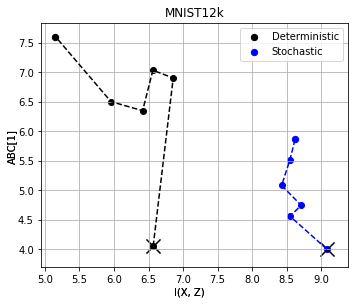

In [310]:
dataset = 'mnist12k'
# dataset = 'cifar10'

if dataset == 'cifar10':
    biases = vib_cifar_biases
else:
    biases = vib_mnist_biases
    
# abc_ind = 'first'
abc_ind = 'second'

layers = [2]
dout_vals = ['0', '0.1', '0.2', '0.325', '0.4', '0.45', '0.6']#, '0.75'] 

fig, ax, abc_vib, mi_vib = build(None, None, dout_vals, dataset, 'dout', col['wd'], name='dout_%s_%s' % (abc_ind, dataset), comment='determ', folder='abc_vs_mi', tog=True, loc=1, biases=biases, annotate=False, abc_ind=abc_ind)#True)
ax.grid()
ax.grid()
ax.grid()
fig, ax, _, _ = build(fig, ax, dout_vals, dataset, 'dout', col['dout'], name='dout_%s_%s' % (abc_ind, dataset), folder='abc_vs_mi', comment='stoch', tog=True, loc=1, biases=biases, annotate=False, abc_ind=abc_ind)#True)
ax.grid()
ax.grid()


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


                                              2
0        (0.4162989898989995, 4.05567676767676)
1e-7    (0.3696151515151544, 4.077548484848492)
1e-6   (0.30489090909091965, 3.959624242424246)
1e-5  (0.43631414141415126, 4.1716030303030305)
1e-6
                                             2
0      (4.348662714841109, 2.3574850538112817)
1e-7   (4.638722240960312, 2.3755679387540116)
1e-6    (4.627988307846211, 2.374093562799786)
1e-5  (4.9340685505975825, 2.3794583095373616)
experiments_2007/results/mnist12k/abc_vs_mi/wd_first_mnist12k.png


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


saved information plane
                                              2
0      (0.28698484848486505, 4.004562626262629)
1e-7    (0.5442818181818293, 4.176770707070713)
1e-6    (0.40934343434341836, 4.13634343434343)
1e-5  (0.36394444444444407, 4.0721444444444455)
0
                                            2
0      (7.15492114933947, 2.3605132631744663)
1e-7   (7.709471742283733, 2.357433227582109)
1e-6   (7.743668914304835, 2.364361911832342)
1e-5  (7.248092168247886, 2.3620218156585633)
experiments_2007/results/mnist12k/abc_vs_mi/wd_first_mnist12k.png
saved information plane


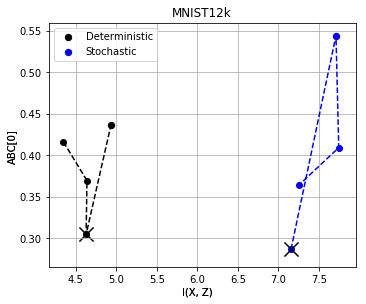

In [321]:
dataset = 'mnist12k'
# dataset = 'cifar10'

if dataset == 'cifar10':
    biases = vib_cifar_biases
else:
    biases = vib_mnist_biases

layers = [2]
wd_vals = ['0', '1e-7', '1e-6', '1e-5']#, '5e-4']#, '1e-3', '5e-3']#, '1e-2', '5e-2']    
abc_ind = 'first'
# abc_ind = 'second'

fig, ax, abc_vib, mi_vib = build(None, None, wd_vals, dataset, 'wd', col['wd'], name = 'wd_%s_%s' % (abc_ind, dataset),comment='determ', folder='abc_vs_mi', tog=True, loc=2, biases=biases, annotate=False, abc_ind=abc_ind)#True)
ax.grid()
ax.grid()
ax.grid()
fig, ax, _, _ = build(fig, ax, wd_vals, dataset, 'wd', col['dout'], name = 'wd_%s_%s' % (abc_ind, dataset), folder='abc_vs_mi', comment='stoch', tog=True, loc=2, biases=biases, annotate=False, abc_ind=abc_ind)#True)
ax.grid()
ax.grid()

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


                                              2
0       (0.6169777777777984, 4.784155555555551)
1e-8    (0.5884929292929331, 4.619092929292928)
1e-7     (0.525111111111113, 4.181466666666659)
1e-6   (0.3009050505050429, 4.1274383838383875)
1e-5  (0.24947575757575474, 4.2966313131313125)
1e-4   (0.26610606060605324, 4.674106060606058)
1e-3   (0.6707292929292803, 5.9706404040404095)
1e-5
MIE experiment for  with vib (5e-5) for mnist12k is missing
MIE experiment for  with vib (5e-4) for mnist12k is missing
                                             2
0      (8.769414664866437, 2.3011744857496685)
1e-8   (6.538115320468233, 2.3005997150497786)
1e-7    (4.852139459534414, 2.303049332937077)
1e-6  (3.5697452766188067, 2.2953914862729254)
1e-5   (2.799700199292293, 2.2810504697925524)
1e-4   (2.600487202162308, 2.2804723191828966)
1e-3     (2.6685613929705, 2.2891642628917634)
experiments_2007/results/mnist12k/abc_vs_mi/ib_first_mnist12k.png
saved information plane


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


                                              2
0       (0.6420222222222032, 4.535066666666672)
1e-8    (0.5887454545454495, 4.403878787878787)
1e-7    (0.3035686868686913, 3.879968686868688)
1e-6  (0.16497474747473878, 3.5045525252525267)
1e-5  (0.22227676767676438, 3.8550323232323214)
1e-4    (0.3102414141414266, 4.679930303030304)
1e-3   (0.25903737373738006, 5.267504040404035)
1e-6
MIE experiment for unit with ceb (5e-5) for mnist12k is missing
MIE experiment for unit with ceb (5e-4) for mnist12k is missing
                                             2
0       (8.876827974636397, 2.301025161684032)
1e-8    (6.326220799154708, 2.301072933035237)
1e-7     (4.72867184793843, 2.302526713815473)
1e-6  (2.4939480044184235, 2.3033141548529468)
1e-5   (3.1621085087978646, 2.295712174588725)
1e-4  (2.3763718011998933, 2.3029046751227638)
1e-3    (2.360418114179655, 2.298483924290963)
experiments_2007/results/mnist12k/abc_vs_mi/ib_first_mnist12k.png
saved information plane
                 

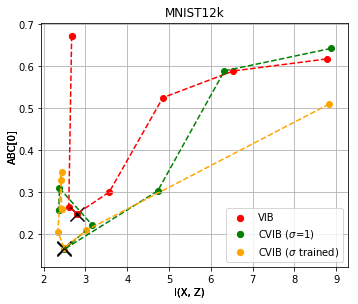

In [317]:
vib_cifar_biases = {}#'1e-3': [-0.08, 0.003], '5e-5': [0.04, 0.001], '1e-4': [0.04, -0.001], '1e-5':[-0.02, -0.005], '1e-6': [-0.06, 0.002], '1e-7': [0.04, 0.001], '0': [-0.06, -0.004], '1e-8': [-0.08, -0.005]}
vib_mnist_biases = {}#'1e-8': [-0.06, 0.001], '1e-7': [-0.06, 0.001], '1e-6': [0.04, -0.001], '5e-2': [0.04, -0.001], '1e-2': [-0.48, 0], '1e-4': [0.07, -0.001], '1e-5': [0.05, 0]}

dataset = 'mnist12k'
# dataset = 'cifar10'

if dataset == 'cifar10':
    biases = vib_cifar_biases
else:
    biases = vib_mnist_biases
    
abc_ind = 'first'
# abc_ind = 'second'

layers = [2]
vib_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3']#, '5e-3', '1e-2']#, '5e-2', '1e-1']#, '5e-1', '1'] 

fig, ax, abc_vib, mi_vib = build(None, None, vib_vals, dataset, 'vib', col['vib'], name='ib_%s_%s' % (abc_ind, dataset), folder='abc_vs_mi', tog=True, loc=4, biases=biases, annotate=False, abc_ind=abc_ind)#True)
ax.grid()
ax.grid()
fig, ax, _, _ = build(fig, ax, vib_vals, dataset, 'ceb', col['ceb'], folder='abc_vs_mi', name='ib_%s_%s' % (abc_ind, dataset), comment='unit', tog=True, loc=4, biases=biases, annotate=False, abc_ind=abc_ind)#True)
ax.grid()
ax.grid()
fig, ax, _, _ = build(fig, ax, vib_vals, dataset, 'ceb', 'orange', folder='abc_vs_mi', name='ib_%s_%s' % (abc_ind, dataset), comment='learnt', tog=True, loc=4, biases=biases, annotate=False, abc_ind=abc_ind)#True)
ax.grid()
ax.grid()

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


MIE experiment for stoch with dout (0.4) for mnist12k is missing
MIE experiment for stoch with dout (0.475) for mnist12k is missing
                                             2
0        (9.08205829298213, 2.302764648549139)
0.1    (8.548473922799504, 2.3007989878692325)
0.2    (8.710162265683932, 2.3004726663965083)
0.325   (8.426730255091941, 2.299172791765321)
0.45   (8.547747618811474, 2.3009254744388747)
0.6     (8.623024655301421, 2.299825108943004)
0.75   (7.793144441161837, 2.2867883713661667)
experiments_2007/results/mnist12k/information_planes/dout.png


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


saved information plane
MIE experiment for determ with dout (0.4) for mnist12k is missing
MIE experiment for determ with dout (0.475) for mnist12k is missing
                                              2
0       (6.566880129131058, 2.3040218695596093)
0.1      (6.857159304564434, 2.303940120154904)
0.2    (6.5625232511652385, 2.3026055607861937)
0.325   (6.413990142094712, 2.3024883471760482)
0.45     (5.954573684728573, 2.301802107741435)
0.6      (5.15207302316432, 2.2984283778402523)
0.75    (4.755709529459952, 2.1914861764439504)
experiments_2007/results/mnist12k/information_planes/dout.png
saved information plane


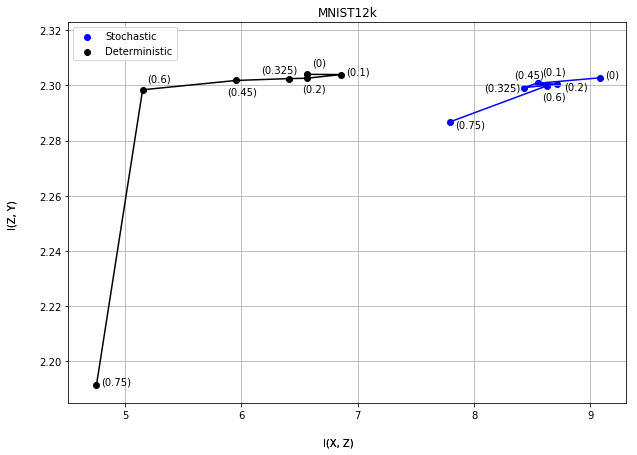

In [24]:
#Dropout 
layers = [2]#[0, 1, 2]
colors = get_colors(4)
col = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}

dout_vals = ['0', '0.1', '0.2', '0.325', '0.4', '0.45', '0.475', '0.6', '0.75'] 

stoch_cifar_biases = {'0.1': [0, -0.04], '0.325': [0, -0.04], '0.4': [-0.04, 0.02], '0.475': [0.05, 0]}


# fig, ax = build(None, None, dout_vals, 'cifar10', 'dout', col['dout'], comment='stoch', name='comp_dout', tog=True, biases=stoch_cifar_biases)
# ax.grid()
# fig, ax = build(fig, ax, dout_vals, 'cifar10', 'dout', col['wd'], comment='determ', name='comp_dout', tog=True)


determ_mnist_biases = {'0': [0.04, 0.003], '0.1': [0.04, 0], '0.2': [-0.04, -0.005], '0.325': [-0.24, 0.002], '0.45': [-0.08, -0.005], '0.6': [0.04, 0.003]}


stoch_mnist_biases = {'0.1': [0.04, 0.003], '0.2': [0.06, -0.002], '0.325': [-0.34, -0.001], '0.45': [-0.2, 0.002], '0.6': [-0.04, -0.005], '0.75': [0.04, -0.002]}
fig, ax = build(None, None, dout_vals, 'mnist12k', 'dout', col['dout'], comment='stoch', tog=True, loc=2, biases=stoch_mnist_biases)
ax.grid()
fig, ax = build(fig, ax, dout_vals, 'mnist12k', 'dout', col['wd'], comment='determ', tog=True, loc=2, biases=determ_mnist_biases)

# build(dout_vals, 'mnist12k', 'dout', comment='stoch', name='test')
# build(dout_vals, 'mnist12k', 'dout', comment='determ', name='test')





# do_abc = make_abc_df(do_vals, 'cifar10', layers, 'dout', comment='stoch')
# do_mie = make_mie_df(do_vals, 'cifar10', layers, 'dout', comment='stoch')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(do_mie, 'cifar10', do_abc, 'dout', fig, ax, c=col['wd'], title=cifar10_title, comment='stoch')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(do_mie, 'cifar10', do_abc, 'dout', fig, ax, folder='gap', c=col['wd'], title=cifar10_title, comment='stoch')
# del(do_abc)
# del(do_mie)

# do_abc = make_abc_df(do_vals, 'cifar10', layers, 'dout', comment='determ')
# do_mie = make_mie_df(do_vals, 'cifar10', layers, 'dout', comment='determ')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(do_mie, 'cifar10', do_abc, 'dout', fig, ax, c=col['dout'], title=cifar10_title, comment='determ')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(do_mie, 'cifar10', do_abc, 'dout', fig, ax, folder='gap', c=col['dout'], title=cifar10_title, comment='determ')
# del(do_abc)
# del(do_mie)

# do_abc = make_abc_df(do_vals, 'mnist12k', layers, 'dout', comment='stoch')
# do_mie = make_mie_df(do_vals, 'mnist12k', layers, 'dout', comment='stoch')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(do_mie, 'mnist12k', do_abc, 'dout', fig, ax, c=col['wd'], title=mnist12k_title, comment='stoch')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(do_mie, 'mnist12k', do_abc, 'dout', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='determ')
# del(do_abc)
# del(do_mie)


# do_abc = make_abc_df(do_vals, 'mnist12k', layers, 'dout', comment='determ')
# do_mie = make_mie_df(do_vals, 'mnist12k', layers, 'dout', comment='determ')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(do_mie, 'mnist12k', do_abc, 'dout', fig, ax, c=col['dout'], title=mnist12k_title, comment='determ')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(do_mie, 'mnist12k', do_abc, 'dout', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='determ')


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


                                              2
0        (0.4162989898989995, 4.05567676767676)
1e-7    (0.3696151515151544, 4.077548484848492)
1e-6   (0.30489090909091965, 3.959624242424246)
1e-5  (0.43631414141415126, 4.1716030303030305)
5e-5     (0.298726262626272, 4.043459595959596)
1e-4    (0.2662070707070796, 4.229407070707074)
5e-4    (0.5613656565656323, 5.426432323232323)
1e-3    (0.2868515151515144, 4.976629292929295)
5e-3     (0.7441070707070598, 6.99999595959596)


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


KeyError: 0

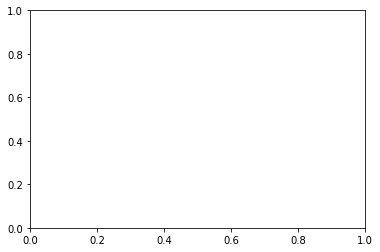

In [74]:
# comparisons
# wd: stoch vs determ

# def wd_comparison(wd_vals, dataset, plot_title):
# dataset = 'cifar10'
dataset = 'mnist12k'


mnist12k_biases = {'1e-6': [0.04, -0.001], '1e-7': [-0.24, 0], '5e-4': [0.04, 0.001], '1e-4': [0.04, 0.001]}
cifar10_biases = {}

if dataset == 'cifar10':
    plot_title = cifar10_title
    biases = cifar10_biases
else:
    biases = mnist12k_biases
    plot_title = mnist12k_title

wd_vals = ['0', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3']#, '1e-2', '5e-2']    
    
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
wd_abc = make_abc_df(wd_vals, dataset, layers, 'wd', comment='determ')
wd_mie = make_mie_df(wd_vals, dataset, layers, 'wd', comment='determ')
for i in wd_abc.index.values:
    tmp = wd_abc.loc[i, 2]
    wd_abc.loc[i, 2] = transform(tmp[0], tmp[1])
#     print(wd_abc)
# print(wd_mie)
# wd_abc = wd_abc.drop(index='5e-5')
wd_mie = wd_mie.drop(index='5e-5')
fig, ax = information_plane(wd_mie, dataset, wd_abc, 'Weight Decay', fig, ax, c=col['wd'], name='comp_wd', loc=1, title=plot_title, comment='Deterministic', tog=True, biases=biases)
ax.grid()




mnist12k_biases = {'1e-5': [0.03, -0.0015], '1e-6': [-0.04, 0.001], '1e-7': [-0.04, -0.002], '0': [-0.14, -0.001], '5e-4': [0.04, -0.001]}
cifar10_biases = {'1e-4': [-0.24, 0], '1e-6': [-0.24, 0]}

if dataset == 'cifar10':
    plot_title = cifar10_title
    biases = cifar10_biases
else:
    biases = mnist12k_biases
    plot_title = mnist12k_title


wd_abc = make_abc_df(wd_vals, dataset, layers, 'wd', comment='stoch')
wd_mie = make_mie_df(wd_vals, dataset, layers, 'wd', comment='stoch')
for i in wd_abc.index.values:
    tmp = wd_abc.loc[i, 2]
    wd_abc.loc[i, 2] = transform(tmp[0], tmp[1])
#     print(wd_abc)
# print(wd_mie)

# wd_abc = wd_abc.drop(index='5e-5')
wd_mie = wd_mie.drop(index='5e-5')
fig, ax = information_plane(wd_mie, dataset, wd_abc, 'Weight Decay', fig, ax, c=col['dout'], name='comp_wd', loc=1, title=plot_title, comment='Stochastic', tog=True, biases=biases)
    
# wd_comparison(wd_vals, 'mnist12k', mnist12k_title)
# wd_comparison(wd_vals, 'cifar10', cifar10_title)




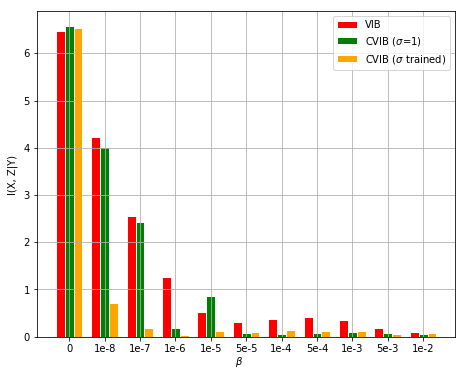

In [296]:
# Visualization of Superfluous information
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25

# set height of bar
bars1 = [val[0][0]-val[0][1] for val in mies[0].values]
bars2 = [val[0][0]-val[0][1] for val in mies[1].values]
bars3 = [val[0][0]-val[0][1] for val in mies[2].values]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
 
# Make the plot
ax.grid()
ax.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='VIB')
ax.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', label=r'CVIB ($\sigma$=1)')
ax.bar(r3, bars3, color='orange', width=barWidth, edgecolor='white', label=r'CVIB ($\sigma$ trained)')
ax.legend()
ax.set_title(dataset.upper())
# Add xticks on the middle of the group bars
fig.text(0.5, 0.06, r'$\beta$', ha='center')
fig.text(0.07, 0.5, 'I(X, Z|Y)', va='center', rotation='vertical')
plt.xticks([r + barWidth for r in range(len(bars1))], vib_vals)
fig.set_size_inches(7.5, 6, forward=True)
save_path = experiment_path+'results/%s/gap/ready/gaps_%s' % (dataset, dataset)
fig.savefig(save_path)#experiment_path+'results/%s/%s/%s%s.png' % (dataset, folder, name if name else reg_type, '_'+comment if not tog else ''))

# Create legend & Show graphic
plt.legend()
plt.show()


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


MIE experiment for  with vib (5e-5) for mnist12k is missing
MIE experiment for  with vib (5e-4) for mnist12k is missing
                                             2
0      (8.769414664866437, 2.3011744857496685)
1e-8   (6.538115320468233, 2.3005997150497786)
1e-7    (4.852139459534414, 2.303049332937077)
1e-6  (3.5697452766188067, 2.2953914862729254)
1e-5   (2.799700199292293, 2.2810504697925524)
1e-4   (2.600487202162308, 2.2804723191828966)
1e-3     (2.6685613929705, 2.2891642628917634)
5e-3  (2.7053283524773417, 2.2924238540610613)
1e-2    (2.626898230243294, 2.280270601482617)
5e-2   (2.4723056424941348, 2.278566625172659)
1e-1  (2.3585030429609244, 2.2690599580109128)
experiments_2007/results/mnist12k/information_planes/vib_VIB.png
saved information plane


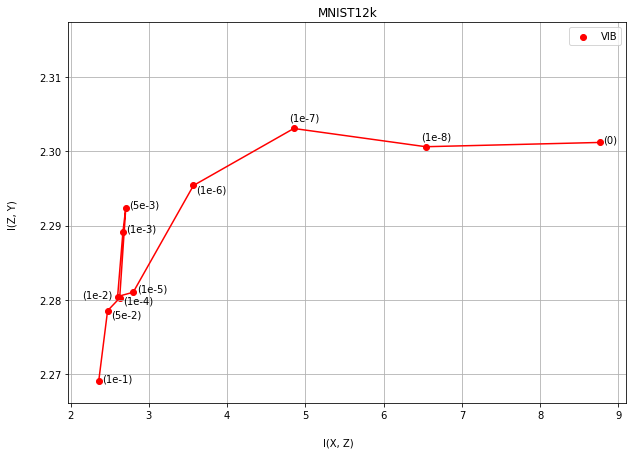

In [43]:
#VIB

layers = [2]
# ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '5e-1']#, '1e-0']
# ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '5e-1']#, '1e-0']
# ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '5e-2', '1e-1', '5e-1', '1', '5']

# ceb_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '5e-3', '5e-3']#, '1e-2', '5e-2', '1e-1', '5e-1', '1', '5']

# cvib_vals = ['1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '5e-2', '1e-1', '5e-1', '1', '5']

# vib_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '5875e-6', '1e-2', '5e-2', '1e-1', '5e-1', '1'] 
vib_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1']#, '5e-1', '1'] 

vib_cifar_biases = {}#'0': [0.04, 0.003], '0.1': [0.04, 0], '0.2': [-0.04, -0.005], '0.325': [-0.24, 0.002], '0.45': [-0.08, -0.005], '0.6': [0.04, 0.003]}


# vib_cifar_biases = {'1e-3': [-0.08, 0.003], '5e-5': [0.04, 0.001], '1e-5':[0.04, -0.002], '1e-6': [-0.06, 0.002], '1e-7': [0.04, 0.001], '0': [-0.06, -0.004], '1e-8': [-0.08, 0.003]}

# vib_abc = make_abc_df(vib_vals, 'cifar10', layers, 'vib')
# vib_mie = make_mie_df(vib_vals, 'cifar10', layers, 'vib')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# ax.grid()
# _ = information_plane(vib_mie, 'cifar10', vib_abc, 'vib', fig, ax, c=col['vib'], title=cifar10_title, comment='VIB', biases=vib_cifar_biases)
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(vib_mie, 'cifar10', vib_abc, 'vib', fig, ax, folder='gap', c=col['vib'], title=cifar10_title)
# del(vib_abc)
# del(vib_mie)

vib_mnist_biases = {'1e-8': [-0.06, 0.001], '1e-7': [-0.06, 0.001], '1e-6': [0.04, -0.001], '5e-2': [0.04, -0.001], '1e-2': [-0.48, 0], '1e-4': [0.07, -0.001], '1e-5': [0.05, 0]}

vib_abc = make_abc_df(vib_vals, 'mnist12k', layers, 'vib')
vib_mie = make_mie_df(vib_vals, 'mnist12k', layers, 'vib')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
ax.grid()
ax.grid()
_ = information_plane(vib_mie, 'mnist12k', vib_abc, 'vib', fig, ax, c=col['vib'], title=mnist12k_title, comment='VIB', biases=vib_mnist_biases)
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(vib_mie, 'mnist12k', vib_abc, 'vib', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title)
# del(vib_abc)
# del(vib_mie)

In [ ]:
vib_cifar_biases = {'1e-3': [0, 0.001]}

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: 

MIE experiment for stoch with wd (5e-4) for cifar10 is missing
MIE experiment for stoch with wd (1e-3) for cifar10 is missing
MIE experiment for stoch with wd (5e-3) for cifar10 is missing
                                                    2
0             (5.653499208168819, 2.3189171507674406)
1e-7          (5.216211574556623, 2.2970935697755914)
1e-6          (5.487209976265691, 2.3168571576139283)
1e-5           (5.608464185253901, 2.308697187563747)
5e-5  (-3.664394879955994e-05, -9.02934364288168e-06)
1e-4          (6.3803476970629385, 2.226544898772738)
0          blue
1e-7    #47caeb
1e-6    #47caeb
1e-5    #339df0
dtype: object
experiments_2007/results/cifar10/information_planes/wd_stoch.png
saved information plane


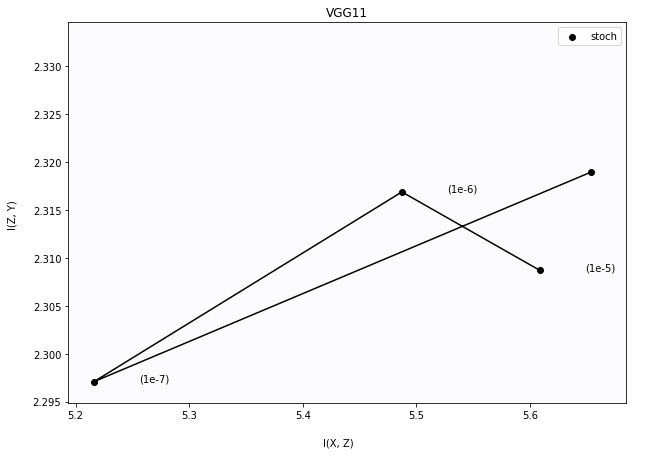

In [50]:
#Weight decay and dropout 
layers = [2]#[0, 1, 2]
#colors = get_colors(4)
from colour import Color

col = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}
# wd_vals = ['0', '1e-7', '1e-6', '75e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2']
wd_vals = ['0', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3']#, '1e-2', '5e-2']


wd_abc = make_abc_df(wd_vals, 'cifar10', layers, 'wd', comment='stoch')
wd_mie = make_mie_df(wd_vals, 'cifar10', layers, 'wd', comment='stoch')
wd_abc = wd_abc.drop(index='5e-5')
wd_mie = wd_mie.drop(index='5e-5')

wd_abc = wd_abc.drop(index='1e-4')
wd_mie = wd_mie.drop(index='1e-4')



final_colors = create_colors(wd_abc, 5, 2)
print(final_colors)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
ax.set_facecolor((0.99, 0.99, 1.0))
_ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, c=col['wd'], final_c=final_colors, title=cifar10_title, comment='stoch')
#  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, folder='gap', c=col['wd'], final_c=final_colors, title=cifar10_title, comment='stoch')
# del(wd_abc)
# del(wd_mie)

# wd_abc = make_abc_df(wd_vals, 'cifar10', layers, 'wd', comment='determ')
# wd_mie = make_mie_df(wd_vals, 'cifar10', layers, 'wd', comment='determ')
# for i in wd_abc.index.values:
#     tmp = wd_abc.loc[i, 2]
#     wd_abc.loc[i, 2] = transform(tmp[0], tmp[1])
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, c=col['dout'], title=cifar10_title, comment='determ')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, folder='gap', c=col['dout'], title=cifar10_title, comment='determ')
# del(wd_abc)
# del(wd_mie)

# wd_abc = make_abc_df(wd_vals, 'mnist12k', layers, 'wd', comment='stoch')
# wd_mie = make_mie_df(wd_vals, 'mnist12k', layers, 'wd', comment='stoch')
# for i in wd_abc.index.values:
#     tmp = wd_abc.loc[i, 2]
#     wd_abc.loc[i, 2] = transform(tmp[0], tmp[1])
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(wd_mie, 'mnist12k', wd_abc, 'wd', fig, ax, c=col['wd'], title=mnist12k_title, comment='stoch')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(wd_mie, 'mnist12k', wd_abc, 'wd', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='stoch')
# del(wd_abc)
# del(wd_mie)


# wd_abc = make_abc_df(wd_vals, 'mnist12k', layers, 'wd', comment='determ')
# wd_mie = make_mie_df(wd_vals, 'mnist12k', layers, 'wd', comment='determ')
# for i in wd_abc.index.values:
#     tmp = wd_abc.loc[i, 2]
#     wd_abc.loc[i, 2] = transform(tmp[0], tmp[1])
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(wd_mie, 'mnist12k', wd_abc, 'wd', fig, ax, c=col['dout'], title=mnist12k_title, comment='determ')
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
# _ = information_plane(wd_mie, 'mnist12k', wd_abc, 'wd', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='determ')

In [15]:
# CVIB

# cvib_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1']#, '5e-1', '1'] 
cvib_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1']#, '5e-1', '1'] 


cvib_abc = make_abc_df(cvib_vals, 'cifar10', layers, 'ceb', comment='unit')
cvib_mie = make_mie_df(cvib_vals, 'cifar10', layers, 'ceb', comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, c=col['wd'], title=cifar10_title, comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, folder='gap', c=col['dout'], title=cifar10_title, comment='unit')
del(cvib_abc)
del(cvib_mie)

cvib_abc = make_abc_df(cvib_vals, 'cifar10', layers, 'ceb', comment='learnt')
cvib_mie = make_mie_df(cvib_vals, 'cifar10', layers, 'ceb', comment='learnt')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, c=col['wd'], title=cifar10_title, comment='learnt')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, folder='gap', c=col['dout'], title=cifar10_title, comment='learnt')
del(cvib_abc)
del(cvib_mie)

cvib_abc = make_abc_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
cvib_mie = make_mie_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, c=col['wd'], title=mnist12k_title, comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='unit')
del(cvib_abc)
del(cvib_mie)


cvib_abc = make_abc_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='learnt')
cvib_mie = make_mie_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='learnt')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, c=col['wd'], title=mnist12k_title, comment='learnt')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='learnt')



NameError: name 'make_abc_df' is not defined

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


MIE experiment for determ with dout (0.4) for mnist12k is missing
MIE experiment for determ with dout (0.475) for mnist12k is missing
                                              2
0       (6.566880129131058, 2.3040218695596093)
0.1      (6.857159304564434, 2.303940120154904)
0.2    (6.5625232511652385, 2.3026055607861937)
0.325   (6.413990142094712, 2.3024883471760482)
0.45     (5.954573684728573, 2.301802107741435)
0.6      (5.15207302316432, 2.2984283778402523)
0.75    (4.755709529459952, 2.1914861764439504)
                                                 2
0      (0.012406529829297344, 0.12086715561903623)
0.1     (0.06849973674933388, 0.20576628406015435)
0.2     (0.06337087799220957, 0.20968795232866672)
0.325   (0.06574690774798493, 0.18925024324505044)
0.45     (0.06283197409397151, 0.1938771946904041)
0.6     (0.09408355360882688, 0.22666589356911754)
0.75       (0.417126909559728, 1.0401622495435627)
saved information plane
MIE experiment for stoch with dout (0.4) for mnist

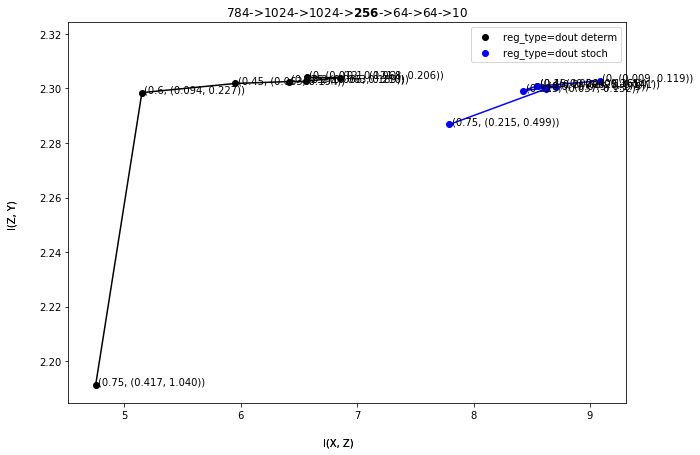

In [227]:
# comparisons
# dout: stoch vs determ

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
dout_abc = make_abc_df(dout_vals, 'mnist12k', layers, 'dout', comment='determ')
dout_mie = make_mie_df(dout_vals, 'mnist12k', layers, 'dout', comment='determ')
print(dout_abc)
# wd_abc = wd_abc.drop(index='5e-5')
# wd_mie = wd_mie.drop(index='5e-5')
fig, ax = information_plane(dout_mie, 'mnist12k', dout_abc, 'dout', fig, ax, c=col['wd'], name='comp_dout', loc=1, title=mnist12k_title, comment='determ', tog=True)

dout_abc = make_abc_df(dout_vals, 'mnist12k', layers, 'dout', comment='stoch')
dout_mie = make_mie_df(dout_vals, 'mnist12k', layers, 'dout', comment='stoch')
# wd_abc = wd_abc.drop(index='5e-5')
# wd_mie = wd_mie.drop(index='5e-5')
fig, ax = information_plane(dout_mie, 'mnist12k', dout_abc, 'dout', fig, ax, c=col['dout'], name='comp_dout', loc=1, title=mnist12k_title, comment='stoch', tog=True)

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: 

MIE experiment for unit with ceb (1e-2) for cifar10 is missing
MIE experiment for unit with ceb (5e-2) for cifar10 is missing
MIE experiment for unit with ceb (1e-1) for cifar10 is missing
                                            2
0      (8.631749499647933, 2.276894659402817)
1e-8   (8.311480691186762, 2.294242573204996)
1e-7  (6.056280671959816, 2.2890026590191286)
1e-6   (4.640843732111361, 2.278211324016253)
1e-5  (3.8332142757513346, 2.276479281191021)
5e-5  (3.327712958120836, 2.2731714026829457)
1e-4  (3.4800880811241024, 2.264643917350347)
5e-4  (3.298609888155125, 2.2544399635053667)
1e-3   (2.99408041996784, 2.2634155024473483)
5e-3    (2.79070595520613, 2.178717729881167)
saved information plane
                                               2
0      (0.19471583415532373, 0.9914383773293785)
1e-8   (0.10885048973712336, 0.8961821011664444)
1e-7   (0.07725091954728205, 0.8356448185234201)
1e-6   (0.06898568947133417, 0.8592776298780143)
1e-5   (0.03601026168631093, 0.81372

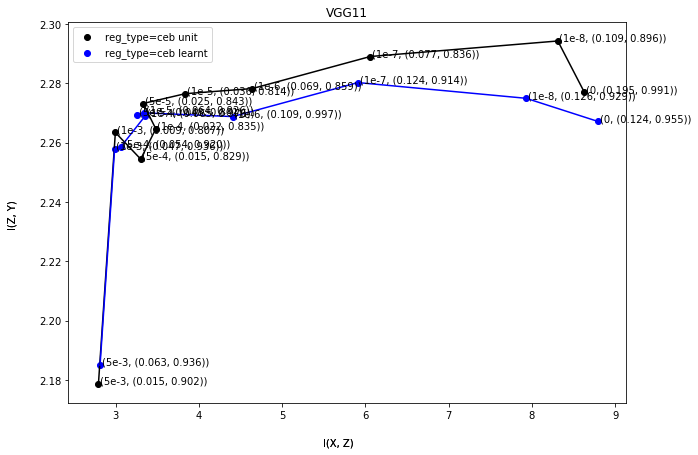

In [251]:
# comparison
# cvib: unit vs learnt

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

cvib_abc = make_abc_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
cvib_mie = make_mie_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
fig, ax = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, c=col['wd'], name='comp_cvib', title=mnist12k_title, comment='unit', tog=True)
print(cvib_abc)

cvib_abc = make_abc_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='learnt')
cvib_mie = make_mie_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='learnt')
fig, ax = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, c=col['dout'], name='comp_cvib', title=mnist12k_title, comment='learnt', tog=True)
print(cvib_abc)


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

cvib_abc = make_abc_df(cvib_vals, 'cifar10', layers, 'ceb', comment='unit')
cvib_mie = make_mie_df(cvib_vals, 'cifar10', layers, 'ceb', comment='unit')
fig, ax = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, c=col['wd'], name='comp_cvib', title=cifar10_title, comment='unit', tog=True)
print(cvib_abc)

cvib_abc = make_abc_df(cvib_vals, 'cifar10', layers, 'ceb', comment='learnt')
cvib_mie = make_mie_df(cvib_vals, 'cifar10', layers, 'ceb', comment='learnt')
fig, ax = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, c=col['dout'], name='comp_cvib', title=cifar10_title, comment='learnt', tog=True)
print(cvib_abc)


saved information plane
saved information plane


NameError: name 'vib_mie' is not defined

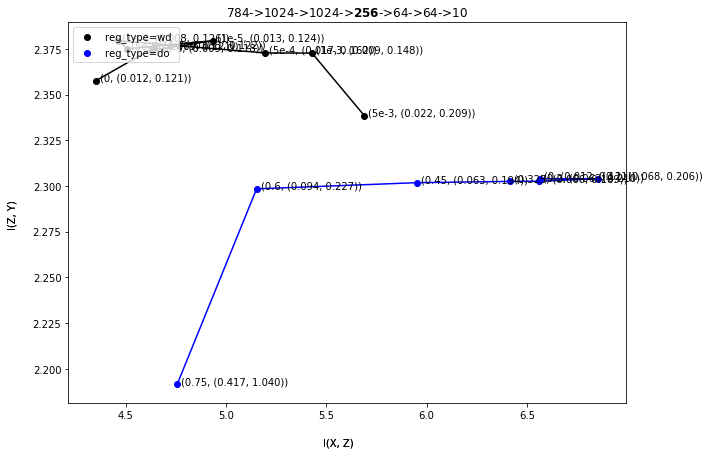

In [198]:
# comparison: cvib (unit) vs vib

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

vib_abc = make_abc_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
vib_mie = make_mie_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
fig, ax = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, c=col['wd'], name='comp_cvib', title=mnist12k_title, comment='unit', tog=True)
print(cvib_abc)

cvib_abc = make_abc_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='learnt')
cvib_mie = make_mie_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='learnt')
fig, ax = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, c=col['dout'], name='comp_cvib', title=mnist12k_title, comment='learnt', tog=True)
print(cvib_abc)


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

cvib_abc = make_abc_df(cvib_vals, 'cifar10', layers, 'ceb', comment='unit')
cvib_mie = make_mie_df(cvib_vals, 'cifar10', layers, 'ceb', comment='unit')
fig, ax = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, c=col['wd'], name='comp_cvib', title=cifar10_title, comment='unit', tog=True)
print(cvib_abc)

cvib_abc = make_abc_df(cvib_vals, 'cifar10', layers, 'ceb', comment='learnt')
cvib_mie = make_mie_df(cvib_vals, 'cifar10', layers, 'ceb', comment='learnt')
fig, ax = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, c=col['dout'], name='comp_cvib', title=cifar10_title, comment='learnt', tog=True)
print(cvib_abc)

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

fig, ax = information_plane(wd_mie, wd_abc, 'wd', fig, ax, c=col['wd'], name='allin1', loc=2, title=cifar10_title)
fig, ax = information_plane(do_mie, do_abc, 'do', fig, ax, c=col['dout'], name='allin1', loc=2, title=cifar10_title)
fig, ax = information_plane(vib_mie, vib_abc, 'vib', fig, ax, c=col['vib'], name='allin1', loc=2, title=cifar10_title)






In [310]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import umap-learn 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(context='notebook', style='white', rc={'figure.figsize':(14,10)})
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target,
                                                    stratify=digits.target,
                                                    random_state=42)


ModuleNotFoundError: No module named 'umap.umap_'; 'umap' is not a package

In [309]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train)

AttributeError: module 'umap' has no attribute 'UMAP'

In [97]:
#building variational gaps
var_path = 'var_gaps'
# dataset = 'mnist12k'
dataset = 'cifar10'
vib_mie = make_mie_df(vib_vals, dataset, layers, 'vib')
cvib_unit_mie = make_mie_df(cvib_vals, dataset, layers, 'ceb', comment='learnt')
cvib_learnt_mie = make_mie_df(cvib_vals, dataset, layers, 'ceb', comment='learnt')

def compute_var_gaps(mie_df, layers, dataset, reg_type, comment=''):
    gaps_df = pd.DataFrame(columns=layers)
    folder = 'var_gaps/'
    if reg_type == 'wd':
        folder += dataset+'/wd'
    elif reg_type == 'dout':
        folder += dataset+'/dropout'
    elif reg_type == 'vib':
        folder += dataset+'/vib'
    elif reg_type == 'ceb' or reg_type == 'cvib':
        folder += dataset+'/ceb'
        
    vals = mie_df.index.values
    for layer in layers:
        for val in vals:
            path = folder + '/' + val + ('/' + comment if comment != '' else '')
            try:
                f_names = sort(os.listdir(path))
            
                for name in f_names:
                    if name != '.DS_Store':
                        with open(path+'/'+name, 'r') as f:
                            value = f.read()
                    gaps_df.loc[val, layer] = value
            except Exception as e:
                print(e)
                
        if reg_type == 'vib':
            gaps_df[layer] = gaps_df[layer].apply(float)
            gaps_df[layer] -= mie_df[layer].apply(get_x)
        elif reg_type =='ceb' or reg_type =='cvib':
            gaps_df[layer] = gaps_df[layer].apply(float)
            gaps_df[layer] -= mie_df[layer].apply(get_x) - mie_df[layer].apply(get_y)
    return gaps_df


var_gap_df = pd.DataFrame(columns=['VIB', r'CVIB $\sigma$=1', r'CVIB $\sigma$ trained'])

var_gap_df['VIB'] = compute_var_gaps(vib_mie, layers, dataset, 'vib')[layers[-1]]
var_gap_df[r'CVIB $\sigma$=1'] = compute_var_gaps(cvib_unit_mie, layers, dataset, 'cvib', comment='unit')[layers[-1]]
var_gap_df[r'CVIB $\sigma$ trained'] = compute_var_gaps(cvib_learnt_mie, layers, dataset, 'cvib', comment='learnt')[layers[-1]]

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


MIE experiment for  with vib (1e-2) for cifar10 is missing
MIE experiment for  with vib (5e-2) for cifar10 is missing
MIE experiment for  with vib (1e-1) for cifar10 is missing
                                             2
0        (7.61392553688539, 2.283591407766139)
1e-8     (8.121399255653051, 2.28880367553585)
1e-7    (6.805568491664251, 2.294384815378744)
1e-6    (5.168762767144672, 2.291365798535737)
1e-5   (4.279155745226517, 2.2777798457329097)
5e-5    (3.883256635526932, 2.280430927535296)
1e-4   (3.7605422682883263, 2.273828227627538)
5e-4  (3.2732647248129685, 2.2472897575757442)
1e-3   (3.291549939066243, 2.2581444934035972)
5e-3   (3.141268636169229, 2.1881644558136744)
MIE experiment for learnt with ceb (1e-2) for cifar10 is missing
MIE experiment for learnt with ceb (5e-2) for cifar10 is missing
MIE experiment for learnt with ceb (1e-1) for cifar10 is missing
                                             2
0      (8.795979907886542, 2.2671130012447014)
1e-8   (7.9314926

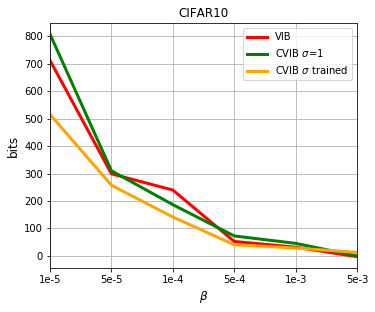

In [120]:
dataset = 'cifar10'
# dataset = 'mnist12k'

var_gap_df = pd.DataFrame(columns=['VIB', r'CVIB $\sigma$=1', r'CVIB $\sigma$ trained'])

var_gap_df['VIB'] = compute_var_gaps(vib_mie, layers, dataset, 'vib')[layers[-1]]
var_gap_df[r'CVIB $\sigma$=1'] = compute_var_gaps(cvib_unit_mie, layers, dataset, 'cvib', comment='unit')[layers[-1]]
var_gap_df[r'CVIB $\sigma$ trained'] = compute_var_gaps(cvib_learnt_mie, layers, dataset, 'cvib', comment='learnt')[layers[-1]]
%matplotlib inline 
plot = var_gap_df.drop(['1e-6', '1e-7', '1e-8', '0'], axis=0).plot(color=['red', 'green', 'orange'], figsize=(5.5, 4.5), linewidth=3)
plot.set_xlabel(r'$\beta$',fontsize=12)
plot.set_ylabel(r'bits',fontsize=12)
plot.set_title(dataset.upper())
plot.grid()
plot.get_figure().savefig('var_gaps/var_gap_%s.png' % dataset)
plt.show()

# '1e-6', '1e-7', '1e-8', 

In [72]:
plot.set_xlabel(r'$\beta$',fontsize=12)
plot.set_ylabel(r'bits',fontsize=12)
plt.show()

In [10]:
import umap.umap_ as umap
from models import Stochastic
import torch

z_test = torch.rand([1000, 256]).cpu().data.numpy()
y_test = torch.randint(0, 9, [1000, 256]).cpu().data.numpy()








umap_features = umap.UMAP().fit_transform(z_test)



In [13]:
umap_features.shape[0]

1000

ValueError: 'c' argument has 1000 elements, which is not acceptable for use with 'x' with size 1000, 'y' with size 1000.

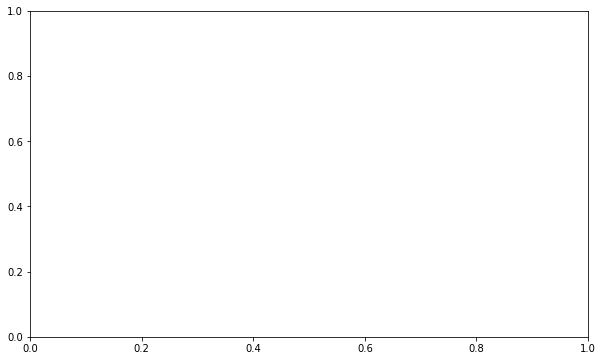

In [11]:
fig = plt.figure(figsize=(10, 6))

# plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_test[:tsne_features.shape[0]], marker='o',
            # edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)

plt.scatter(umap_features[:, 0], umap_features[:, 1], c=y_test[:umap_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('off')
plt.colorbar()
plt.show
# fig.savefig(FLAGS.result_path+'/pca_manifold.png')

In [124]:
!pip uninstall umap

Skipping umap as it is not installed.
